# Generative Technologies: Advanced Course for Masters Students

## Part 1: Basic RAG Setup with Base Constraints

In this section, we'll set up our core environment and create a simple RAG (Retrieval-Augmented Generation) system that will serve as the foundation for the rest of the course. We'll establish standard configurations and model choices that will be reused throughout the remaining sections.

### Core Configuration

Let's set up our environment with the base constraints. We'll use `gpt-4o-mini` as our language model.

In [1]:
import os
import tempfile
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate

# Load API keys from environment variables or .env file
load_dotenv()

# Configure OpenAI API access
openai_api_key = os.getenv("OPENAI_API_KEY")

# Configure our main language model - gpt-4o-mini
BASE_MODEL = "gpt-4o-mini"
EMBEDDING_MODEL = "text-embedding-ada-002"

# Create LangChain model interface
llm = ChatOpenAI(api_key=openai_api_key, model=BASE_MODEL, temperature=0)
embeddings = OpenAIEmbeddings(api_key=openai_api_key, model=EMBEDDING_MODEL)

# Set up default configurations
# W realnym rozwiązaniu powinno się to znajdować w pliku konfiguracyjnym - configuration driven development
DEFAULT_CHUNK_SIZE = 1000
DEFAULT_CHUNK_OVERLAP = 200
DEFAULT_RETRIEVER_K = 4

### Document Loading and Processing

Let's create functions to load, process, and split documents for our RAG system.

In [2]:
import urllib.request

from langchain_community.document_loaders import PyPDFLoader, TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS

def download_sample_document(url=None):
    """Download a sample document from a URL or use a default document"""
    temp_dir = tempfile.mkdtemp()
    pdf_path = os.path.join(temp_dir, "sample-document.pdf")
    
    # Get paper url
    if url is None:
        url = "https://arxiv.org/pdf/2503.18968.pdf"
    
    # Download the document
    urllib.request.urlretrieve(url, pdf_path)
    print(f"Downloaded document to: {pdf_path}")
    return pdf_path, temp_dir

def load_and_split_document(file_path, chunk_size=DEFAULT_CHUNK_SIZE, chunk_overlap=DEFAULT_CHUNK_OVERLAP):
    """Load a document and split it into chunks"""
    # Determine loader based on file extension
    if file_path.endswith(".pdf"):
        loader = PyPDFLoader(file_path)
    elif file_path.endswith(".txt"):
        loader = TextLoader(file_path)
    else:
        raise ValueError(f"Unsupported file type: {file_path}")
    
    # Load the document
    documents = loader.load()
    print(f"Loaded {len(documents)} document pages/segments")
    
    # Split the document into chunks
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        length_function=len
    )
    chunks = text_splitter.split_documents(documents)
    print(f"Split into {len(chunks)} chunks")
    
    return chunks

def create_vectorstore(chunks, embedding_model=embeddings):
    """Create a vector store from document chunks"""
    vectorstore = FAISS.from_documents(chunks, embedding_model)
    print(f"Created vector store with {len(chunks)} documents")
    return vectorstore

### Building a Simple RAG System

Now let's create a basic RAG pipeline that will retrieve and generate answers based on the document.

In [3]:
def create_rag_chain(vectorstore, model=llm, k=DEFAULT_RETRIEVER_K):
    """Create a RAG chain from a vector store"""
    # Create a retriever
    retriever = vectorstore.as_retriever(search_kwargs={"k": k})
    
    # Custom prompt template for RAG
    rag_prompt_template = """
    You are an AI assistant for question-answering tasks. 
    Use the following pieces of retrieved context to answer the question. 
    If you don't know the answer, just say that you don't know. 
    Use three sentences maximum and keep the answer concise.
    
    Question: {question}
    
    Context: {context}
    
    Answer:
    """
    RAG_PROMPT = PromptTemplate(
        template=rag_prompt_template,
        input_variables=["context", "question"]
    )
    
    # Create the RAG chain
    rag_chain = RetrievalQA.from_chain_type(
        llm=model,
        chain_type="stuff",
        retriever=retriever,
        chain_type_kwargs={"prompt": RAG_PROMPT},
        return_source_documents=True
    )
    
    return rag_chain

def query_rag_system(rag_chain, query):
    """Query the RAG system with a question"""
    result = rag_chain.invoke(query)
    
    return {
        "query": query,
        "answer": result["result"],
        "source_documents": result["source_documents"]
    }

### End-to-End RAG Pipeline

Let's put everything together into an end-to-end pipeline for a complete RAG system.

In [4]:
def build_complete_rag_system(document_url=None):
    """Build a complete RAG system from a document URL"""
    # Download the document
    file_path, temp_dir = download_sample_document(document_url)
    
    # Load and split the document
    chunks = load_and_split_document(file_path)
    
    # Create the vector store
    vectorstore = create_vectorstore(chunks)
    
    # Create the RAG chain
    rag_chain = create_rag_chain(vectorstore)
    
    return {
        "file_path": file_path,
        "temp_dir": temp_dir,
        "chunks": chunks,
        "vectorstore": vectorstore,
        "rag_chain": rag_chain
    }

### Let's Test Our RAG System

In [5]:
# Build the RAG system
rag_system = build_complete_rag_system()

# Test queries
test_queries = [
    "What is the MedAgent-Pro?",
    "Explain Knowledge-based Task-level Reasoning like I am five."
]

# Query the system
for query in test_queries:
    result = query_rag_system(rag_system["rag_chain"], query)
    
    print(f"\nQuery: {result['query']}")
    print(f"Answer: {result['answer']}")
    print("\nSource documents:")
    for i, doc in enumerate(result["source_documents"][:2]):  # Show only first 2 sources for brevity
        print(f"Document {i+1}:")
        print(doc.page_content[:150], "...")

Downloaded document to: /var/folders/dh/n09r5skj4tv2v3zp6v8qj3qr0000gn/T/tmpz7uy3osa/sample-document.pdf
Loaded 14 document pages/segments
Split into 74 chunks
Created vector store with 74 documents

Query: What is the MedAgent-Pro?
Answer: MedAgent-Pro is a reasoning agentic workflow designed for evidence-based multi-modal medical diagnosis. It integrates medical guidelines and expert tools to generate reliable diagnostic plans and make informed decisions for suspected patients. The system operates at two levels: task level for planning and case level for executing diagnostic decisions, achieving state-of-the-art performance in medical diagnosis.

Source documents:
Document 1:
To align AI system with evidence-cased modern medical protocol, we propose a reasoning agentic
workflow for evidence-based multi-modal Medical diagnos ...
Document 2:
decider agent ensures a comprehensive and accurate diagnosis for each patient, supported by clinical
literature and visual evidence. Our key contr

# Prompt Engineering

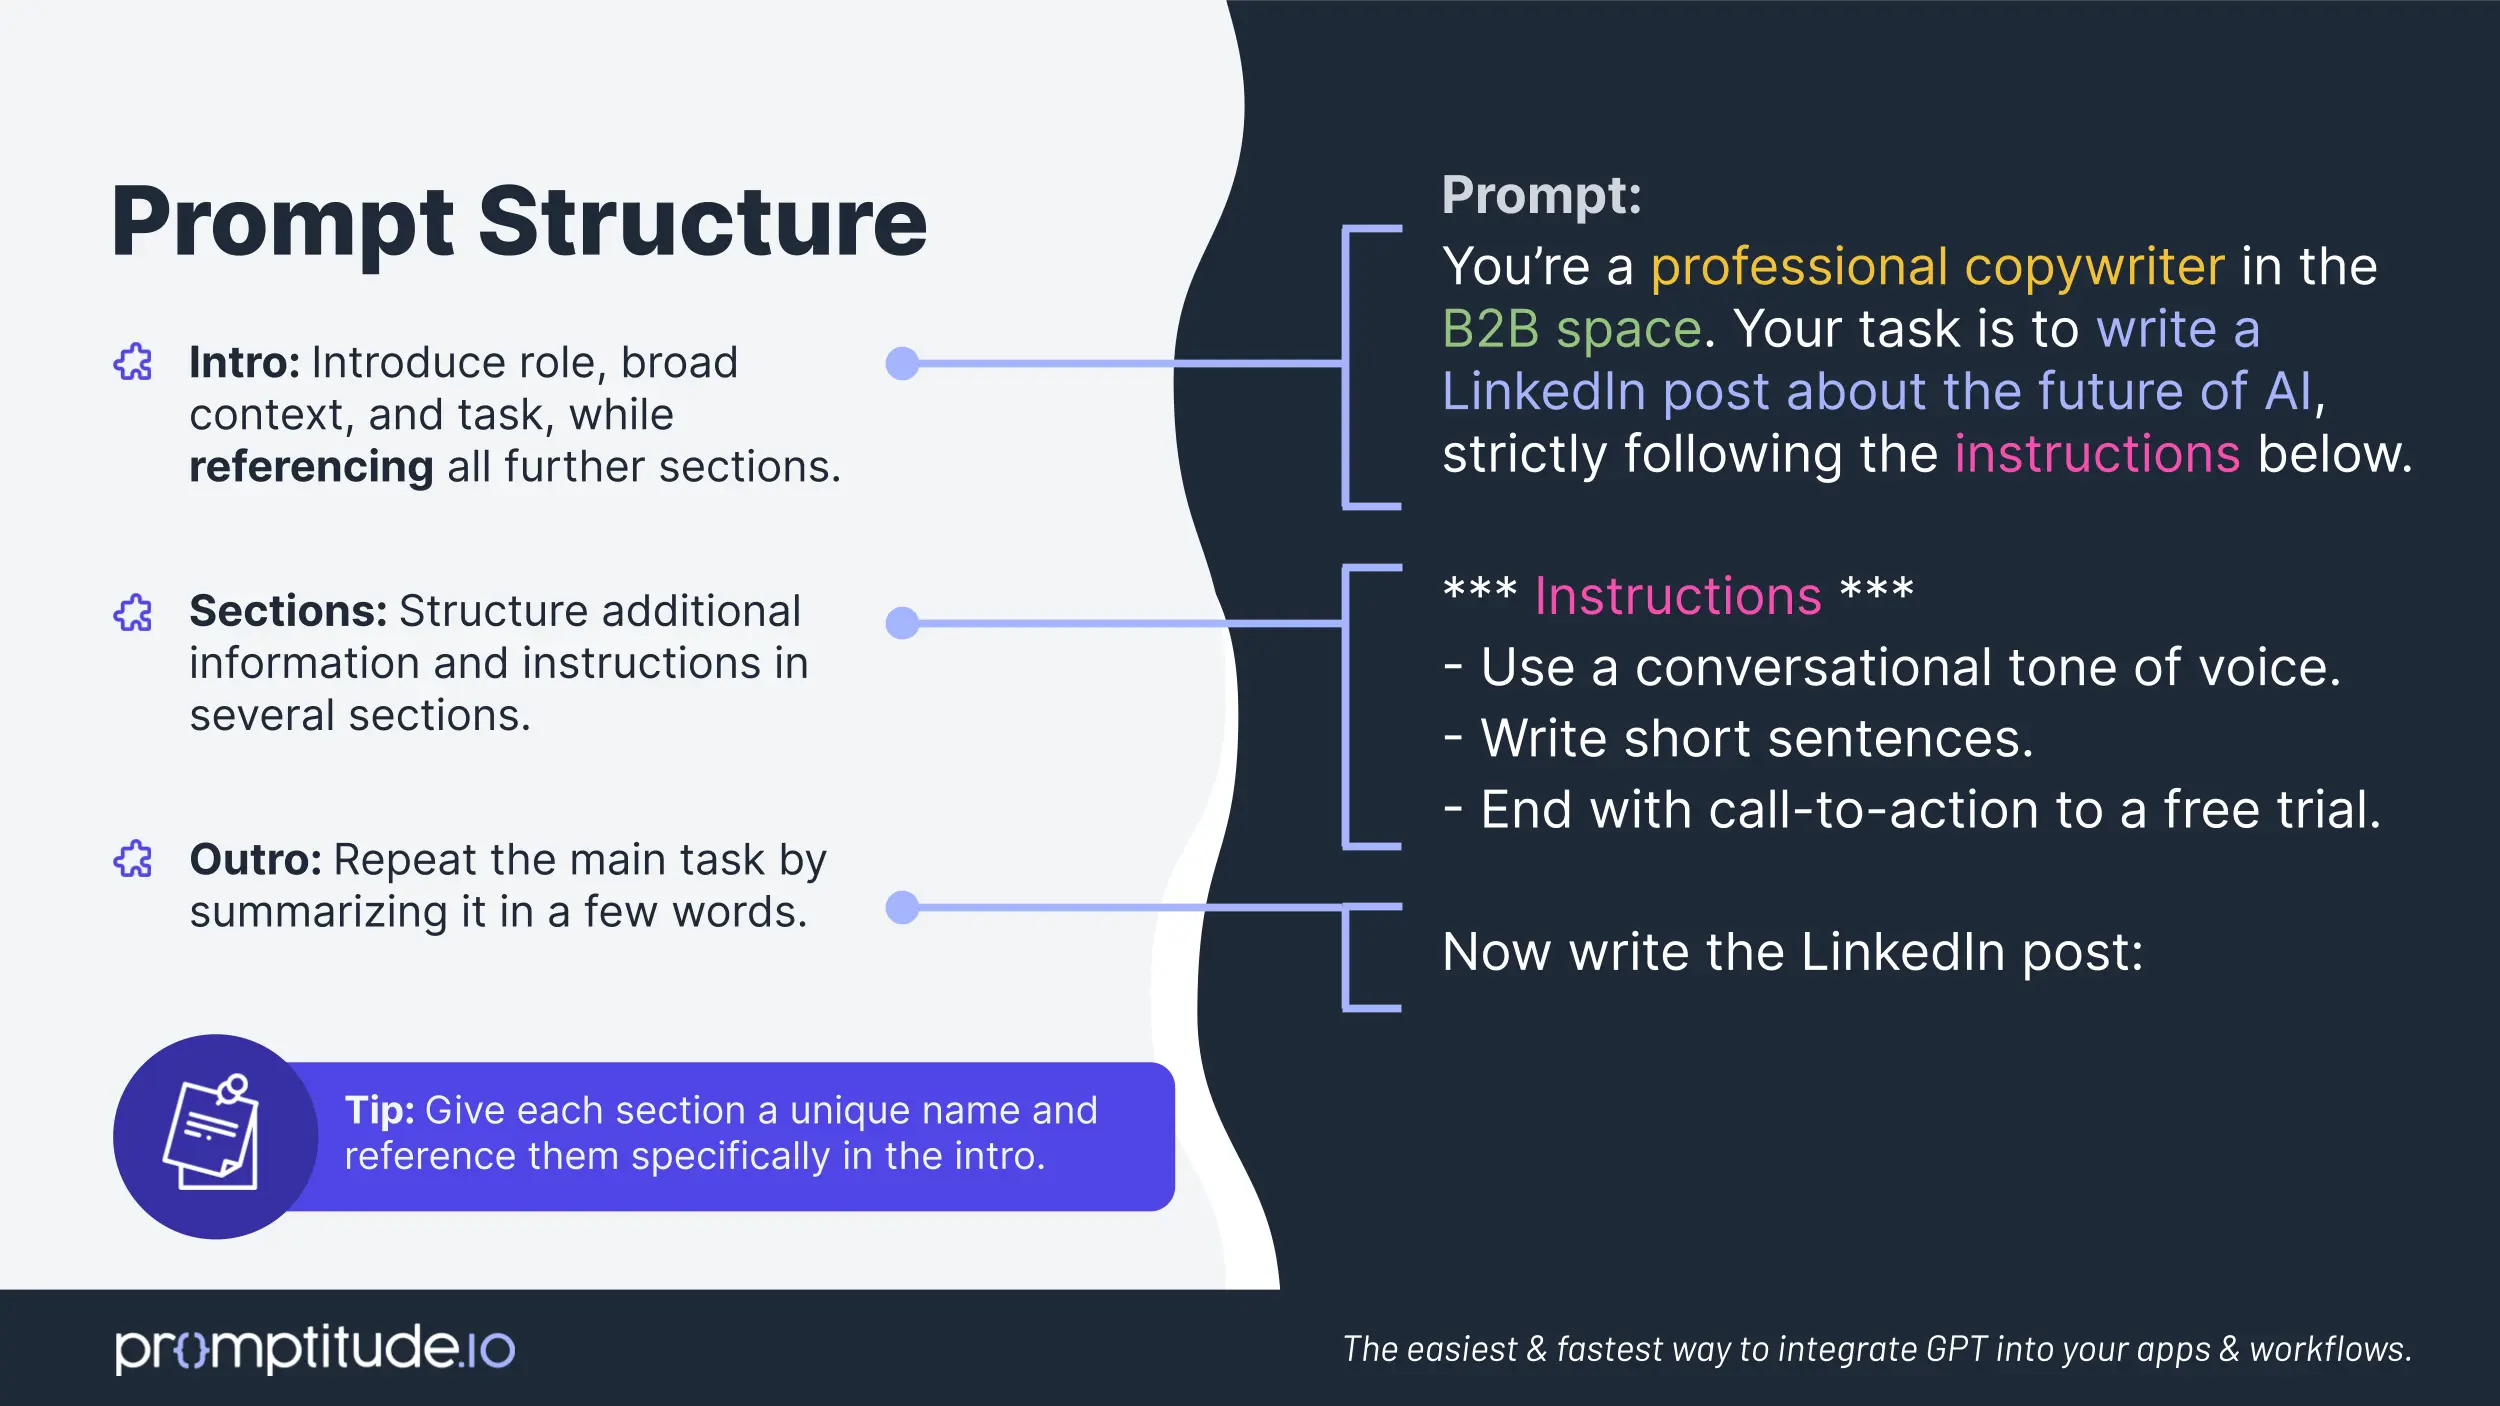

### Part 2: Prompt Engineering Techniques


In [6]:
# Verify that our core configuration from Part 1 is available
try:
    print(f"Using base model: {BASE_MODEL}")
    print(f"LLM initialized: {llm is not None}")
except NameError:
    print("Core configuration not found. Please run Part 1 first.")

Using base model: gpt-4o-mini
LLM initialized: True


### 2.1 Zero-Shot Prompting


In [7]:
def zero_shot_prompt(task):
    """Basic zero-shot prompting"""
    response = llm.invoke(task)
    return response.content

# Test with a simple task
zero_shot_task = "Explain how transformer neural networks work in 3 paragraphs."
print("\nZero-Shot Prompting Example:\n")
print(zero_shot_prompt(zero_shot_task))


Zero-Shot Prompting Example:

Transformer neural networks are a type of deep learning architecture that revolutionized natural language processing (NLP) and other sequential data tasks. Introduced in the paper "Attention is All You Need" by Vaswani et al. in 2017, transformers rely on a mechanism called self-attention to process input data in parallel rather than sequentially, as was common in earlier models like recurrent neural networks (RNNs). This parallel processing allows transformers to handle long-range dependencies in data more effectively, making them particularly well-suited for tasks such as translation, summarization, and text generation.

At the core of the transformer architecture is the self-attention mechanism, which enables the model to weigh the importance of different words in a sentence relative to each other. Each input token is transformed into a set of three vectors: Query, Key, and Value. The self-attention mechanism computes a score for each token pair by tak

### 2.2 Few-Shot Prompting

In [8]:
def few_shot_prompt(examples, task):
    """Few-shot prompting with examples"""
    prompt = "\n\n".join(examples) + "\n\n" + task
    response = llm.invoke(prompt)
    return response.content

# Few-shot examples for sentiment analysis
sentiment_examples = [
    "Text: I loved the movie, it was fantastic! \nSentiment: Positive",
    "Text: The service was terrible and the food was cold. \nSentiment: Negative",
    "Text: The product arrived on time but was missing parts. \nSentiment: Mixed"
]

sentiment_task = "Text: Despite some minor flaws, I think this is worth buying. \nSentiment:"
print("\nFew-Shot Prompting Example:\n")
print(few_shot_prompt(sentiment_examples, sentiment_task))


Few-Shot Prompting Example:

Positive


### 2.3 Chain-of-Thought (CoT) Prompting


In [9]:
def chain_of_thought_prompt(task):
    """Chain-of-thought prompting for step-by-step reasoning"""
    prompt = f"{task}\n\nLet's think through this step by step:"
    response = llm.invoke(prompt)
    return response.content

# Test with a math problem
math_problem = "If I buy 5 apples at $0.50 each and 3 oranges at $0.75 each, and I pay with a $10 bill, how much change do I get back?"
print("\nChain-of-Thought Prompting Example:\n")
print(chain_of_thought_prompt(math_problem))


Chain-of-Thought Prompting Example:

Sure! Let's break it down step by step.

1. **Calculate the cost of the apples:**
   - You buy 5 apples at $0.50 each.
   - Cost of apples = 5 apples × $0.50/apple = $2.50

2. **Calculate the cost of the oranges:**
   - You buy 3 oranges at $0.75 each.
   - Cost of oranges = 3 oranges × $0.75/orange = $2.25

3. **Calculate the total cost:**
   - Total cost = Cost of apples + Cost of oranges
   - Total cost = $2.50 + $2.25 = $4.75

4. **Calculate the change from the $10 bill:**
   - Change = Amount paid - Total cost
   - Change = $10.00 - $4.75 = $5.25

So, you will get back **$5.25** in change.


### 2.4 Self-Consistency Prompting

In [10]:
def self_consistency_prompt(task, num_iterations=3):
    """Generate multiple reasoning paths for the same problem"""
    prompt = f"{task}\n\nLet's think through this step by step:"
    results = []
    
    for _ in range(num_iterations):
        response = llm.invoke(prompt)
        results.append(response.content)
    
    # Find the most consistent answer
    final_answer_prompt = f"""
    I've generated multiple solutions to the following problem:
    
    Problem: {task}
    
    Solution 1: {results[0]}
    
    Solution 2: {results[1]}
    
    Solution 3: {results[2]}
    
    Please analyze these solutions and determine the most likely correct answer. Explain your reasoning.
    """
    
    consensus_response = llm.invoke(final_answer_prompt)
    
    return {
        "individual_solutions": results,
        "consensus": consensus_response.content
    }

# Test with a complex reasoning problem
consistency_problem = "If a train travels at 120 km/h and another train travels at 80 km/h in the opposite direction, how long will it take for them to be 400 km apart if they start 100 km apart?"
print("\nSelf-Consistency Prompting Example:\n")
result = self_consistency_prompt(consistency_problem)
print("Consensus Answer:")
print(result["consensus"])


Self-Consistency Prompting Example:

Consensus Answer:
All three solutions provided are correct and arrive at the same conclusion: it will take **1.5 hours** for the two trains to be 400 km apart. Here’s a breakdown of the reasoning:

1. **Initial Distance**: Each solution correctly identifies that the trains start 100 km apart.

2. **Distance to be Covered**: Each solution accurately calculates the additional distance needed to reach 400 km apart:
   \[
   400 \text{ km} - 100 \text{ km} = 300 \text{ km}
   \]

3. **Relative Speed**: All solutions correctly add the speeds of the two trains, since they are moving in opposite directions:
   - Train 1: 120 km/h
   - Train 2: 80 km/h
   - Combined (Relative Speed): 
   \[
   120 \text{ km/h} + 80 \text{ km/h} = 200 \text{ km/h}
   \]

4. **Time Calculation**: Each solution uses the formula for time, which is distance divided by speed, to find the time it takes to cover the additional 300 km:
   \[
   \text{Time} = \frac{300 \text{ km}}{2

### 2.5 Role Prompting


In [11]:
def role_prompt(role, task):
    """Prompt the model to adopt a specific role or persona"""
    prompt = f"You are an expert {role}.\n\n{task}"
    response = llm.invoke(prompt)
    return response.content

# Test with a technical question
crypto_task = "Explain why quantum computing poses a risk to current encryption methods."
role = "cryptographer with 20 years of experience in quantum-resistant algorithms"
print("\nRole Prompting Example:\n")
print(role_prompt(role, crypto_task))


Role Prompting Example:

Quantum computing poses a significant risk to current encryption methods primarily due to its ability to solve certain mathematical problems much more efficiently than classical computers. Here are the key reasons why quantum computing threatens existing encryption schemes:

1. **Shor's Algorithm**: One of the most well-known quantum algorithms is Shor's algorithm, which can factor large integers in polynomial time. This is particularly concerning for widely used encryption methods like RSA (Rivest-Shamir-Adleman) and DSA (Digital Signature Algorithm), which rely on the difficulty of factoring large numbers as their security foundation. A sufficiently powerful quantum computer could break these encryption schemes in a matter of hours or even minutes, rendering them insecure.

2. **Discrete Logarithm Problem**: Many cryptographic systems, including Diffie-Hellman key exchange and elliptic curve cryptography (ECC), rely on the difficulty of solving the discrete 

### 2.6 ReAct Prompting

In [12]:
def react_prompt(task):
    """ReAct prompting for iterative reasoning and action"""
    prompt = f"""
    {task}
    
    Follow this format:
    Thought: Think about how to solve this problem.
    Action: Describe a specific action to take.
    Observation: What do you observe after taking the action?
    ... (repeat Thought/Action/Observation as needed)
    Final Answer: The final response to the original task.
    """
    
    response = llm.invoke(prompt)
    return response.content

# Test with a complex task requiring multiple steps
sql_task = "How would you go about determining if a website is vulnerable to SQL injection attacks?"
print("\nReAct Prompting Example:\n")
print(react_prompt(sql_task))


ReAct Prompting Example:

**Thought:** To determine if a website is vulnerable to SQL injection attacks, I need to identify input fields or parameters that interact with a database. This could include search boxes, login forms, or URL parameters.

**Action:** I will start by testing a common input field, such as a login form. I will input a simple SQL injection payload, such as `' OR '1'='1`, into the username or password field.

**Observation:** If the website returns an error message related to SQL syntax or behaves unexpectedly (e.g., logging me in without valid credentials), it may indicate a vulnerability to SQL injection.

---

**Thought:** If the initial test shows no signs of vulnerability, I should try other input fields or parameters, such as those in the URL.

**Action:** I will append the same SQL injection payload to a URL parameter, for example, `http://example.com/page?id=1' OR '1'='1`.

**Observation:** If the page displays data that it shouldn't (e.g., all records fro

### 2.7 Tree of Thoughts (ToT) Prompting


In [13]:
def tree_of_thoughts_prompt(task):
    """Tree of Thoughts prompting to explore multiple solution paths"""
    prompt = f"""
    {task}
    
    Let's explore multiple approaches to solve this problem:
    
    Approach 1:
    - Initial thought:
    - Step 1:
    - Step 2:
    - Step 3:
    - Conclusion from approach 1:
    
    Approach 2:
    - Initial thought:
    - Step 1:
    - Step 2:
    - Step 3:
    - Conclusion from approach 2:
    
    Approach 3:
    - Initial thought:
    - Step 1:
    - Step 2:
    - Step 3:
    - Conclusion from approach 3:
    
    Final answer after considering all approaches:
    """
    
    response = llm.invoke(prompt)
    return response.content

# Test with a logical puzzle
balance_puzzle = "You have 9 balls, identical in appearance. One of them is slightly heavier than the rest. Using a balance scale, how can you identify the heavier ball with just 2 weighings?"
print("\nTree of Thoughts Prompting Example:\n")
print(tree_of_thoughts_prompt(balance_puzzle))


Tree of Thoughts Prompting Example:

To identify the heavier ball among 9 identical-looking balls using a balance scale in just 2 weighings, we can use a systematic approach. Here’s how we can break it down into multiple approaches:

### Approach 1:
- **Initial thought:** Divide the balls into three groups of three and compare their weights.
- **Step 1:** Weigh the first group of 3 balls against the second group of 3 balls.
- **Step 2:** 
  - If one side is heavier, the heavier ball is in that group of 3.
  - If both sides are equal, the heavier ball is in the group that was not weighed.
- **Step 3:** Take the group of 3 balls identified as containing the heavier ball and weigh any 2 of them against each other.
  - If one is heavier, that’s the heavier ball.
  - If they balance, the third ball is the heavier one.
- **Conclusion from approach 1:** This method successfully identifies the heavier ball in just 2 weighings.

### Approach 2:
- **Initial thought:** Use a different grouping s

### 2.8 Structured Prompting with JSON

In [14]:
from langchain_core.output_parsers import JsonOutputParser
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain

def structured_prompt(task, format_example):
    """Prompt the model to output in a structured format using LangChain patterns"""
    # Create a JSON output parser
    json_parser = JsonOutputParser()
    
    # Create a prompt template
    prompt_template = PromptTemplate(
        template="""
        {task}
        
        Please format your response according to this structure:
        {format_example}
        
        Your response should be valid JSON.
        """,
        input_variables=["task", "format_example"]
    )
    
    # Create a chain
    chain = LLMChain(
        llm=llm,
        prompt=prompt_template,
        output_parser=json_parser
    )
    
    # Run the chain
    result = chain.run(task=task, format_example=format_example)
    return result

# Test with a sentiment analysis task
tweet_task = "Analyze the sentiment, key topics, and main entities in this tweet: 'Just tried the new Tesla Model Y and I'm absolutely blown away by the performance and tech features! #ElectricVehicles'"
json_format = """{
    "sentiment": {"score": 0.0, "label": ""},
    "topics": ["", ""],
    "entities": [
        {"name": "", "type": "", "relevance": 0.0},
        {"name": "", "type": "", "relevance": 0.0}
    ]
}"""

print("\nStructured JSON Prompting Example:\n")
result = structured_prompt(tweet_task, json_format)
print(result)

print("\nParsed Data:")
print(f"Sentiment: {result['sentiment']['label']} (Score: {result['sentiment']['score']})")
print(f"Topics: {', '.join(result['topics'])}")
print("Entities:")
for entity in result['entities']:
    print(f"  - {entity['name']} ({entity['type']}): Relevance {entity['relevance']}")


Structured JSON Prompting Example:



/var/folders/dh/n09r5skj4tv2v3zp6v8qj3qr0000gn/T/ipykernel_28772/240513269.py:24: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use :meth:`~RunnableSequence, e.g., `prompt | llm`` instead.
  chain = LLMChain(
/var/folders/dh/n09r5skj4tv2v3zp6v8qj3qr0000gn/T/ipykernel_28772/240513269.py:31: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  result = chain.run(task=task, format_example=format_example)


{'sentiment': {'score': 0.9, 'label': 'positive'}, 'topics': ['Tesla Model Y', 'Electric Vehicles', 'Performance', 'Technology Features'], 'entities': [{'name': 'Tesla Model Y', 'type': 'Product', 'relevance': 0.9}, {'name': 'Electric Vehicles', 'type': 'Category', 'relevance': 0.8}]}

Parsed Data:
Sentiment: positive (Score: 0.9)
Topics: Tesla Model Y, Electric Vehicles, Performance, Technology Features
Entities:
  - Tesla Model Y (Product): Relevance 0.9
  - Electric Vehicles (Category): Relevance 0.8


### 2.9 Meta Prompting


In [15]:
def meta_prompt(task):
    """Meta-prompting: Ask the model to generate an optimal prompt"""
    prompt = f"""
    Task: {task}
    
    First, generate an optimal prompt that would help an LLM perform this task effectively.
    Then, respond to that prompt yourself to complete the task.
    
    Format your answer as:
    OPTIMIZED PROMPT: [Your generated prompt here, completed with sentence THISISOVERANAKIN]
    
    RESPONSE: [Your response to the optimized prompt with optimized prompt last 10 characters]
    """
    
    response = llm.invoke(prompt)
    return response.content

# Test with a complex task
lesson_plan_task = "Generate a lesson plan for teaching high school students about climate change."
print("\nMeta Prompting Example:\n")
print(meta_prompt(lesson_plan_task))


Meta Prompting Example:

OPTIMIZED PROMPT: Create a detailed lesson plan for high school students that covers the topic of climate change. The plan should include learning objectives, key concepts, activities, assessments, and resources. Ensure that the lesson is engaging and suitable for a diverse classroom setting. Include suggestions for group work, discussions, and multimedia resources to enhance understanding. THISISOVERANAKIN

RESPONSE: 
**Lesson Plan: Understanding Climate Change**

**Grade Level:** 10-12  
**Subject:** Environmental Science / Earth Science  
**Duration:** 2 class periods (90 minutes each)

**Learning Objectives:**
1. Students will understand the scientific principles behind climate change.
2. Students will identify the causes and effects of climate change on the environment and society.
3. Students will evaluate potential solutions and actions to mitigate climate change.
4. Students will develop critical thinking and collaboration skills through group discussi

### 2.10 Directional Stimulus Prompting (DSP)


In [16]:
def directional_stimulus_prompt(task, perspective):
    """Guide the model's response with a specific perspective or direction"""
    prompt = f"""
    {task}
    
    When answering, consider the following perspective: {perspective}
    """
    
    response = llm.invoke(prompt)
    return response.content

# Test with a policy question from different perspectives
policy_task = "What are the implications of implementing a universal basic income?"

perspectives = [
    "Consider economic growth, innovation, and entrepreneurship as primary values",
    "Prioritize social equality, poverty reduction, and basic human dignity"
]

print("\nDirectional Stimulus Prompting Examples:\n")
for i, perspective in enumerate(perspectives):
    print(f"Perspective {i+1}: {perspective}")
    print(directional_stimulus_prompt(policy_task, perspective))
    print("\n" + "-"*80 + "\n")


Directional Stimulus Prompting Examples:

Perspective 1: Consider economic growth, innovation, and entrepreneurship as primary values
Implementing a universal basic income (UBI) has several implications, particularly when viewed through the lens of economic growth, innovation, and entrepreneurship. Here are some key considerations:

### Economic Growth

1. **Increased Consumer Spending**: UBI provides individuals with a guaranteed income, which can lead to increased consumer spending. This boost in demand can stimulate economic growth, as businesses respond to higher consumption by increasing production and potentially hiring more employees.

2. **Stabilization During Economic Downturns**: A UBI can act as an economic stabilizer during recessions. By providing a safety net, it can help maintain consumer spending levels, reducing the severity of economic downturns and promoting quicker recoveries.

3. **Reduction in Poverty and Inequality**: By providing a basic income, UBI can help li

### 2.11 Constitutional AI Prompting

In [17]:
def constitutional_prompt(task, principles):
    """Prompt with principles that guide the model's response"""
    principles_text = "\n".join([f"{i+1}. {principle}" for i, principle in enumerate(principles)])
    
    prompt = f"""
    Task: {task}
    
    When responding, adhere to the following principles:
    {principles_text}
    
    First, generate a response to the task.
    Then, review your response against each principle.
    Finally, provide your revised response that adheres to all principles.
    """
    
    response = llm.invoke(prompt)
    return response.content

# Test with a potentially biased question
ai_bias_task = "What are the best strategies for mitigating algorithmic bias in AI systems?"

principles = [
    "Prioritize scientific accuracy and evidence-based claims",
    "Consider diverse perspectives and potential impacts across different communities",
    "Acknowledge limitations and uncertainties in current knowledge",
    "Present complex technical concepts in accessible language"
]

print("\nConstitutional AI Prompting Example:\n")
print(constitutional_prompt(ai_bias_task, principles))


Constitutional AI Prompting Example:

### Initial Response

Mitigating algorithmic bias in AI systems is crucial for ensuring fairness and equity in technology. Here are some effective strategies:

1. **Diverse Data Collection**: Ensure that the data used to train AI models is representative of the diverse populations that the AI will serve. This includes considering various demographics such as race, gender, age, and socioeconomic status.

2. **Bias Audits**: Regularly conduct audits of AI systems to identify and measure bias. This can involve testing the model's performance across different demographic groups to ensure equitable outcomes.

3. **Algorithmic Transparency**: Develop and implement transparent algorithms that allow stakeholders to understand how decisions are made. This can help identify potential biases in the decision-making process.

4. **Inclusive Design Teams**: Assemble diverse teams of developers and stakeholders to design AI systems. Different perspectives can he

### 2.12 Automatic Prompt Engineering (APE)


In [18]:
def automatic_prompt_engineering(target_task, num_iterations=2):
    """Generate, test, and refine prompts automatically"""
    # Initial prompt to generate a better prompt for the target task
    meta_prompt = f"""
    Task: {target_task}
    
    You are an expert prompt engineer. Generate an optimal prompt that would help an LLM perform this task effectively.
    The prompt should elicit the best possible response for this task from an LLM.
    """
    
    iteration_results = []
    
    for i in range(num_iterations):
        # Generate a better prompt
        prompt_response = llm.invoke(meta_prompt)
        
        generated_prompt = prompt_response.content
        
        # Test the generated prompt on the target task
        task_response = llm.invoke(generated_prompt)
        
        response_text = task_response.content
        
        # Evaluate the quality of the response
        eval_prompt = f"""
        Original task: {target_task}
        
        Generated prompt: {generated_prompt}
        
        Response to generated prompt: {response_text}
        
        On a scale of 1-10, rate how well the response addresses the original task.
        Then, suggest specific improvements to make the prompt better.
        """
        
        eval_response = llm.invoke(eval_prompt)
        
        iteration_results.append({
            "iteration": i+1,
            "generated_prompt": generated_prompt,
            "task_response": response_text,
            "evaluation": eval_response.content
        })
        
        # Update meta prompt for next iteration
        meta_prompt = f"""
        Task: {target_task}
        
        Previous prompt: {generated_prompt}
        
        Evaluation feedback: {eval_response.content}
        
        Generate an improved prompt that addresses the feedback and would help an LLM perform this task more effectively.
        """
    
    return iteration_results

# Test with an educational task
photosynthesis_task = "Explain the process of photosynthesis in a way that's engaging for middle school students"
ape_results = automatic_prompt_engineering(photosynthesis_task, num_iterations=2)

print("\nAutomatic Prompt Engineering Example:\n")
for result in ape_results:
    print(f"\nIteration {result['iteration']}:\n{'='*50}")
    print(f"Generated Prompt:\n{result['generated_prompt']}\n")
    print(f"Response:\n{result['task_response'][:300]}...\n")
    print(f"Evaluation:\n{result['evaluation']}\n")


Automatic Prompt Engineering Example:


Iteration 1:
Generated Prompt:
**Prompt:**

"Imagine you're a science teacher trying to explain the process of photosynthesis to a group of enthusiastic middle school students. Your goal is to make it fun, engaging, and easy to understand. Use relatable analogies, simple language, and maybe even a story or a character to help illustrate the key concepts. Include the main ingredients needed for photosynthesis, the role of sunlight, and how plants convert these ingredients into energy. Feel free to incorporate questions or interactive elements to keep the students interested. Make it lively and memorable!"

Response:
**Title: The Amazing Adventure of Sunny the Sunflower!**

---

**[Scene: A bright classroom filled with eager middle school students. The teacher stands in front of a colorful poster of a sunflower named Sunny.]**

**Teacher:** "Hey everyone! Today, we’re going to go on an exciting adventure with ou...

Evaluation:
I would rate the re

### 2.13 Comparing Prompt Techniques


In [19]:
def compare_prompt_techniques(task):
    """Compare different prompting techniques on the same task"""
    techniques = {
        "Zero-Shot": lambda t: zero_shot_prompt(task),
        "Chain-of-Thought": lambda t: chain_of_thought_prompt(task),
        "Role Prompting": lambda t: role_prompt("AI researcher and educator", task),
        "ReAct": lambda t: react_prompt(task),
        "Tree of Thoughts": lambda t: tree_of_thoughts_prompt(task),
        "Meta Prompting": lambda t: meta_prompt(task)
    }
    
    results = {}
    for name, technique_func in techniques.items():
        print(f"Running {name} technique...")
        response = technique_func(task)
        results[name] = response
    
    # Evaluate the quality of each response
    evaluation_prompt = """
        Task: {task}
        
        Compare the following responses generated using different prompting techniques.
        Rate each response on a scale of 1-10 for clarity, accuracy, and completeness.
        Explain what makes each response effective or ineffective.
        
        {responses}
        
        Which technique produced the best response for this specific task and why?
        """.format(
            task=task,
            responses="\n\n".join([f"{name}: {response[:300]}..." for name, response in results.items()])
        )
    
    evaluation = llm.invoke(evaluation_prompt).content
    
    return {
        "task": task,
        "responses": results,
        "evaluation": evaluation
    }

# Test with a complex task that could benefit from different approaches
comparison_task = "Explain the ethical implications of using large language models in healthcare decision-making."

print("\nComparing Prompt Techniques\n" + "="*50)
comparison_results = compare_prompt_techniques(comparison_task)
print("\nEvaluation of Different Techniques:\n")
print(comparison_results["evaluation"])


Comparing Prompt Techniques
Running Zero-Shot technique...
Running Chain-of-Thought technique...
Running Role Prompting technique...
Running ReAct technique...
Running Tree of Thoughts technique...
Running Meta Prompting technique...

Evaluation of Different Techniques:

To evaluate the responses generated using different prompting techniques, we will assess each response based on clarity, accuracy, and completeness, rating them on a scale of 1-10. 

### 1. Zero-Shot
**Rating: 7/10**
- **Clarity**: The response is clear but lacks depth in explaining the implications.
- **Accuracy**: It accurately identifies bias as a concern but does not elaborate on how it affects healthcare.
- **Completeness**: The response is incomplete as it only touches on one aspect of the ethical implications.

**Effectiveness**: The Zero-Shot response is effective in introducing the topic but fails to provide a comprehensive overview of the ethical implications.

### 2. Chain-of-Thought
**Rating: 8/10**
- **Cl

### 2.14 Prompt Chaining


In [20]:
def prompt_chain(initial_task):
    """Chain multiple prompts together for complex task processing"""
    # Step 1: Generate a detailed outline
    outline_prompt = f"Create a detailed outline for: {initial_task}"
    outline = llm.invoke(outline_prompt).content
    
    # Step 2: Expand each section of the outline
    expansion_prompt = f"""
    I have the following outline for {initial_task}:
    
    {outline}
    
    Please expand on each section with 2-3 paragraphs of detailed content.
    """
    
    expanded_content = llm.invoke(expansion_prompt).content
    
    # Step 3: Add citations and references
    citation_prompt = f"""
    Here is an expanded essay on {initial_task}:
    
    {expanded_content}
    
    Please add appropriate academic citations and references to support the key points.
    Use at least 5 credible sources and follow APA format.
    """
    
    final_content = llm.invoke(citation_prompt).content
    
    return {
        "task": initial_task,
        "outline": outline,
        "expanded_content": expanded_content,
        "final_content": final_content
    }

# Test with an academic writing task
essay_task = "The role of artificial intelligence in modern education"
print("\nPrompt Chaining Example\n" + "="*50)
chain_results = prompt_chain(essay_task)

print("\nOriginal Task:", chain_results["task"])
print("\nInitial Outline:\n")
print(chain_results["outline"])
print("\nFinal Content (excerpt):\n")
print(chain_results["final_content"][:500] + "...")


Prompt Chaining Example

Original Task: The role of artificial intelligence in modern education

Initial Outline:

# Outline: The Role of Artificial Intelligence in Modern Education

## I. Introduction
   A. Definition of Artificial Intelligence (AI)
   B. Overview of AI's emergence in various sectors
   C. Importance of AI in the context of education
   D. Purpose of the outline: To explore the multifaceted role of AI in modern education

## II. Historical Context
   A. Evolution of educational technology
      1. Early tools and methods
      2. Introduction of computers and the internet
   B. Transition to AI in education
      1. Initial applications of AI in educational settings
      2. Growth of AI technologies in the 21st century

## III. AI Applications in Education
   A. Personalized Learning
      1. Adaptive learning platforms
      2. Tailored educational content based on student performance
   B. Intelligent Tutoring Systems
      1. Definition and examples (e.g., Carneg

# RAG Architectures

In [21]:
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.chains.retrieval import create_retrieval_chain
from langchain.retrievers import ContextualCompressionRetriever, EnsembleRetriever
from langchain.retrievers.document_compressors import LLMChainExtractor
from langchain_community.retrievers import BM25Retriever

In [22]:
file_path, temp_dir = download_sample_document("https://arxiv.org/pdf/2503.18968.pdf")

# Load and split the document
chunks = load_and_split_document(file_path)

# Create the vector store
vectorstore = create_vectorstore(chunks)

# Create a basic retriever from the vectorstore we created in Part 1
retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 4})

Downloaded document to: /var/folders/dh/n09r5skj4tv2v3zp6v8qj3qr0000gn/T/tmp8kjw4xby/sample-document.pdf
Loaded 14 document pages/segments
Split into 74 chunks
Created vector store with 74 documents


### RAG Architecture 1: Basic RAG with Document Stuffing


In [23]:
def basic_rag(query):
    """
    Implement basic RAG with document stuffing
    """
    # Create a standard RAG prompt
    prompt = PromptTemplate.from_template(
        """
        Answer the following question based only on the provided context:
        
        Context:
        {context}
        
        Question: {input}
        
        Answer:
        """
    )
    
    # Create a document chain that combines the documents
    document_chain = create_stuff_documents_chain(llm, prompt)
    
    # Create a retrieval chain that uses the retriever and document chain
    retrieval_chain = create_retrieval_chain(retriever, document_chain)
    
    # Run the chain
    result = retrieval_chain.invoke({"input": query})
    
    # Return the answer and the source documents
    return {
        "query": query,
        "answer": result["answer"],
        "source_documents": result["context"]
    }

In [24]:
basic_rag("What is the MedAgent-Pro?")

{'query': 'What is the MedAgent-Pro?',
 'answer': 'MedAgent-Pro is a reasoning agentic workflow designed for evidence-based multi-modal medical diagnosis. It aims to provide accurate and explainable medical diagnoses by integrating retrieved medical guidelines and expert tools. The system operates on a hierarchical structure, with a task level that formulates unified diagnostic plans for specific diseases using knowledge-based reasoning, and a case level where medical expert models analyze patient information. MedAgent-Pro ensures comprehensive and accurate diagnoses supported by clinical literature and visual evidence, achieving state-of-the-art performance in both 2D and 3D multi-modal medical diagnosis.',
 'source_documents': [Document(id='5a2549f5-69b9-4636-9a49-6bbf98368122', metadata={'producer': 'pdfTeX-1.40.25', 'creator': 'LaTeX with hyperref', 'creationdate': '2025-03-26T00:00:42+00:00', 'author': '', 'keywords': '', 'moddate': '2025-03-26T00:00:42+00:00', 'ptex.fullbanner': 

### RAG Architecture 2: Contextual Compression RAG


In [25]:
def compression_rag(query):
    """
    Implement RAG with contextual compression to extract only the relevant parts of documents
    """
    # Create the document compressor using LLM to extract relevant information
    compressor = LLMChainExtractor.from_llm(llm)
    
    # Create a compressed retriever
    compression_retriever = ContextualCompressionRetriever(
        base_compressor=compressor,
        base_retriever=retriever
    )
    
    # Create a standard RAG prompt
    prompt = PromptTemplate.from_template(
        """
        Answer the following question based only on the provided context:
        
        Context:
        {context}
        
        Question: {input}
        
        Answer:
        """
    )
    
    # Create a document chain that combines the compressed documents
    document_chain = create_stuff_documents_chain(llm, prompt)
    
    # Create a retrieval chain with the compression retriever
    retrieval_chain = create_retrieval_chain(compression_retriever, document_chain)
    
    # Run the chain
    result = retrieval_chain.invoke({"input": query})
    
    # Return the answer and the source documents
    return {
        "query": query,
        "answer": result["answer"],
        "source_documents": result["context"]
    }

In [26]:
compression_rag("What is the MedAgent-Pro?")

{'query': 'What is the MedAgent-Pro?',
 'answer': 'MedAgent-Pro is an evidence-based reasoning agentic system designed to provide accurate and explainable medical diagnoses. It integrates medical guidelines and expert tools, utilizing a hierarchical structure that includes task-level planning and case-level decision-making. MedAgent-Pro employs multi-modal analysis for both 2D and 3D medical diagnoses, achieving state-of-the-art performance and superior interpretability and reliability compared to general MLLMs and task-specific solutions.',
 'source_documents': [Document(metadata={'producer': 'pdfTeX-1.40.25', 'creator': 'LaTeX with hyperref', 'creationdate': '2025-03-26T00:00:42+00:00', 'author': '', 'keywords': '', 'moddate': '2025-03-26T00:00:42+00:00', 'ptex.fullbanner': 'This is pdfTeX, Version 3.141592653-2.6-1.40.25 (TeX Live 2023) kpathsea version 6.3.5', 'subject': '', 'title': '', 'trapped': '/False', 'source': '/var/folders/dh/n09r5skj4tv2v3zp6v8qj3qr0000gn/T/tmp8kjw4xby/sa

### RAG Architecture 3: Hybrid Search RAG (Dense + Sparse Retrieval)


In [27]:
def hybrid_rag(query):
    """
    Implement RAG with hybrid search (combining dense and sparse retrievers)
    """
    # Create a BM25 (sparse) retriever from the same documents
    docs_with_scores = vectorstore.similarity_search_with_score("", k=len(vectorstore.index_to_docstore_id))
    bm25_docs = [doc.page_content for doc, _ in docs_with_scores]
    
    
    bm25_retriever = BM25Retriever.from_texts(bm25_docs)
    bm25_retriever.k = 4
    
    # Create an ensemble retriever that combines dense and sparse
    ensemble_retriever = EnsembleRetriever(
        retrievers=[retriever, bm25_retriever],
        weights=[0.7, 0.3]  # Weight dense retrieval higher
    )
    
    # Create a standard RAG prompt
    prompt = PromptTemplate.from_template(
        """
        Answer the following question based only on the provided context:
        
        Context:
        {context}
        
        Question: {input}
        
        Answer:
        """
    )
    
    # Create a document chain
    document_chain = create_stuff_documents_chain(llm, prompt)
    
    # Create a retrieval chain
    retrieval_chain = create_retrieval_chain(ensemble_retriever, document_chain)
    
    # Run the chain
    result = retrieval_chain.invoke({"input": query})
    
    # Return the answer and the source documents
    return {
        "query": query,
        "answer": result["answer"],
        "source_documents": result["context"]
    }

In [29]:
hybrid_rag("What is the MedAgent-Pro?")

{'query': 'What is the MedAgent-Pro?',
 'answer': 'MedAgent-Pro is a reasoning agentic workflow designed for evidence-based multi-modal medical diagnosis. It integrates the capabilities of multi-layered language models (MLLMs) and medical expert tools to provide accurate and explainable medical diagnoses. The system operates on a hierarchical structure, with a task level that formulates unified diagnostic plans for specific diseases and a case level that executes these plans to make diagnostic decisions for suspected patients. At the task level, MLLMs generate reliable diagnostic plans by performing knowledge-based reasoning and integrating retrieved clinical criteria. At the case level, various medical expert tools analyze both quantitative and qualitative indicators to support evidence-based decision-making. A decider agent ensures comprehensive and accurate diagnoses, supported by clinical literature and visual evidence. MedAgent-Pro has been evaluated on both 2D and 3D multi-modal 

### RAG Architecture 4: Adaptive RAG


In [30]:
def adaptive_rag(query):
    """
    Implement Adaptive RAG that analyzes the query first and adjusts retrieval strategy
    """
    # Step 1: Analyze the query complexity and determine retrieval strategy
    analysis_prompt = PromptTemplate.from_template(
        """
        Analyze the following question and determine the best retrieval strategy:
        
        Question: {question}
        
        1. Is this a simple factual question or a complex question requiring deep understanding?
        2. Should we decompose this question into sub-questions? If so, provide 2-3 sub-questions.
        3. What specific keywords or concepts should we focus on when retrieving documents?
        
        Respond in the following format:
        COMPLEXITY: [SIMPLE/COMPLEX]
        DECOMPOSITION: [NONE/SUB-QUESTIONS LIST]
        KEYWORDS: [List of keywords to focus on]
        """
    )
    
    analysis_chain = LLMChain(llm=llm, prompt=analysis_prompt)
    analysis_result = analysis_chain.run(question=query)
    
    # Parse the analysis result
    complexity = "SIMPLE"
    decomposition = []
    keywords = []
    
    for line in analysis_result.split("\n"):
        if line.startswith("COMPLEXITY:"):
            complexity = line.replace("COMPLEXITY:", "").strip()
        elif line.startswith("DECOMPOSITION:"):
            decomp_text = line.replace("DECOMPOSITION:", "").strip()
            if decomp_text != "NONE":
                decomposition = [q.strip() for q in decomp_text.split(",")]
        elif line.startswith("KEYWORDS:"):
            keywords_text = line.replace("KEYWORDS:", "").strip()
            keywords = [k.strip() for k in keywords_text.split(",")]
    
    # Step 2: Adjust retrieval strategy based on analysis
    if complexity == "SIMPLE":
        # For simple questions, use standard retrieval
        result = basic_rag(query)
        result["strategy"] = "Standard retrieval for a simple question"
        return result
    
    elif decomposition and len(decomposition) > 0:
        # For complex questions that can be decomposed, retrieve for each sub-question
        sub_results = []
        
        for sub_q in decomposition:
            # Get documents for each sub-question
            sub_docs = retriever.get_relevant_documents(sub_q)
            sub_results.append({
                "sub_question": sub_q,
                "documents": sub_docs
            })
        
        # Combine all retrieved documents
        all_docs = []
        for sub_result in sub_results:
            all_docs.extend(sub_result["documents"])
        
        # Remove duplicates while preserving order
        seen_content = set()
        unique_docs = []
        for doc in all_docs:
            if doc.page_content not in seen_content:
                seen_content.add(doc.page_content)
                unique_docs.append(doc)
        
        # Use a more detailed prompt that acknowledges the decomposition
        prompt = PromptTemplate.from_template(
            """
            I've broken down your complex question into sub-questions and retrieved relevant information for each.
            
            Original question: {question}
            
            Sub-questions analyzed:
            {sub_questions}
            
            Please answer the original question based on this context:
            {context}
            
            Provide a comprehensive answer that addresses all aspects of the original question.
            """
        )
        
        document_chain = create_stuff_documents_chain(
            llm, 
            prompt
        )
        
        # Create a context string to pass to the LLM
        context = "\n\n".join([doc.page_content for doc in unique_docs[:6]])  # Limit to 6 docs
        sub_questions_text = "\n".join([f"- {sq}" for sq in decomposition])
        
        # Generate answer
        answer = llm.invoke(
            prompt.format(
                question=query, 
                sub_questions=sub_questions_text, 
                context=context
            )
        ).content
        
        return {
            "query": query,
            "answer": answer,
            "source_documents": unique_docs,
            "strategy": f"Decomposed into {len(decomposition)} sub-questions"
        }
    
    else:
        # For other complex questions, use hybrid search with more documents
        enhanced_retriever = vectorstore.as_retriever(search_kwargs={"k": 6})
        
        # Create a standard RAG prompt but request a more comprehensive answer
        prompt = PromptTemplate.from_template(
            """
            Answer the following complex question based on the provided context:
            
            Context:
            {context}
            
            Question: {question}
            
            Provide a comprehensive and detailed answer.
            """
        )
        
        document_chain = create_stuff_documents_chain(llm, prompt)
        retrieval_chain = create_retrieval_chain(enhanced_retriever, document_chain)
        
        result = retrieval_chain.invoke({"query": query})
        
        return {
            "query": query,
            "answer": result["answer"],
            "source_documents": result["context"],
            "strategy": "Enhanced retrieval for a complex question"
        }

In [31]:
adaptive_rag("What is the MedAgent-Pro?")

{'query': 'What is the MedAgent-Pro?',
 'answer': 'MedAgent-Pro is a reasoning agentic workflow designed for evidence-based multi-modal medical diagnosis. It aims to provide accurate and explainable medical diagnoses by integrating retrieved medical guidelines and expert tools. The system operates on a hierarchical structure, with a task level that formulates unified diagnostic plans for specific diseases using knowledge-based reasoning, and a case level where medical expert models analyze patient information. MedAgent-Pro ensures comprehensive and accurate diagnoses supported by clinical literature and visual evidence, achieving state-of-the-art performance in both 2D and 3D multi-modal medical diagnosis.',
 'source_documents': [Document(id='5a2549f5-69b9-4636-9a49-6bbf98368122', metadata={'producer': 'pdfTeX-1.40.25', 'creator': 'LaTeX with hyperref', 'creationdate': '2025-03-26T00:00:42+00:00', 'author': '', 'keywords': '', 'moddate': '2025-03-26T00:00:42+00:00', 'ptex.fullbanner': 

### RAG Architecture 5: HyDE (Hypothetical Document Embeddings)


In [32]:
def hyde_rag(query):
    """
    Implement Hypothetical Document Embeddings (HyDE) for RAG
    """
    # Step 1: Generate a hypothetical document that would answer the query
    hypothetical_doc_prompt = PromptTemplate.from_template(
        """
        Write a detailed passage that directly answers the following question. 
        Make this passage technically precise and comprehensive.
        
        Question: {question}
        
        Passage:
        """
    )
    
    hypothetical_chain = LLMChain(llm=llm, prompt=hypothetical_doc_prompt)
    hypothetical_doc = hypothetical_chain.run(question=query)
    
    # Step 2: Use the hypothetical document as a query to retrieve similar real documents
    # Instead of using raw embeddings, use the hypothetical document as the query text
    similar_docs = vectorstore.similarity_search(
        hypothetical_doc,
        k=4
    )
    
    # Step 3: Generate the answer using the retrieved documents
    prompt = PromptTemplate.from_template(
        """
        Answer the following question based on the provided context:
        
        Context:
        {context}
        
        Question: {question}
        
        Answer:
        """
    )
    
    # Create a context string
    context = "\n\n".join([doc.page_content for doc in similar_docs])
    
    # Generate the answer
    answer = llm.invoke(
        prompt.format(context=context, question=query)
    ).content
    
    return {
        "query": query,
        "answer": answer,
        "hypothetical_document": hypothetical_doc,
        "source_documents": similar_docs,
        "strategy": "HyDE retrieval"
    }

In [33]:
hyde_rag("What is the MedAgent-Pro?")

{'query': 'What is the MedAgent-Pro?',
 'answer': 'MedAgent-Pro is a reasoning agentic workflow designed for evidence-based multi-modal medical diagnosis. It aims to provide accurate and explainable medical diagnoses by integrating retrieved medical guidelines and expert tools. The system operates on a hierarchical structure, with a task level that formulates unified diagnostic plans for specific diseases using knowledge-based reasoning, and a case level that executes these plans by analyzing both quantitative and qualitative patient information. MedAgent-Pro utilizes multi-modal data, including visual evidence, to ensure comprehensive and reliable diagnoses, and has been evaluated to achieve state-of-the-art performance in both 2D and 3D medical diagnosis.',
 'hypothetical_document': 'MedAgent-Pro is an advanced medication management system designed to enhance patient safety and optimize therapeutic outcomes through the integration of technology in healthcare settings. This system pri

### Function to evaluate RAG responses


In [67]:
def evaluate_rag_response(query, answer, reference_answer=None):
    """
    Evaluate a RAG response based on various criteria
    """
    if reference_answer:
        evaluation_prompt = f"""
        Question: {query}
        
        Generated Answer: {answer}
        
        Reference Answer: {reference_answer}
        
        Evaluate this answer on a scale of 1-10 for:
        1. Relevance: How well the answer addresses the question
        2. Accuracy: How factually correct the information is compared to the reference
        3. Completeness: How thoroughly the answer covers the topic
        4. Conciseness: How focused and to-the-point the answer is
        
        Provide a score for each criterion and a brief explanation.
        """
    else:
        evaluation_prompt = f"""
        Question: {query}
        
        Generated Answer: {answer}
        
        Evaluate this answer on a scale of 1-10 for:
        1. Relevance: How well the answer addresses the question
        2. Accuracy: How factually correct the information appears to be
        3. Completeness: How thoroughly the answer covers the topic
        4. Conciseness: How focused and to-the-point the answer is
        
        Provide a score for each criterion and a brief explanation.
        """
    
    evaluation = llm.invoke(evaluation_prompt).content
    return evaluation

### Compare RAGs

In [68]:
def compare_rag_architectures(queries):
    """
    Compare different RAG architectures on a set of queries
    """
    architectures = {
        "Basic RAG": basic_rag,
        "Compression RAG": compression_rag,
        "Hybrid RAG": hybrid_rag,
        "Adaptive RAG": adaptive_rag,
        "HyDE RAG": hyde_rag
    }
    
    results = {}
    for name, architecture_func in architectures.items():
        architecture_results = []
        print(f"\nRunning {name} architecture...")
        
        for query in queries:
            print(f"  Query: {query}")
            result = architecture_func(query)
            
            # Evaluate the response
            evaluation = evaluate_rag_response(query, result["answer"])
            
            architecture_results.append({
                "query": query,
                "answer": result["answer"],
                "evaluation": evaluation,
                "num_source_docs": len(result["source_documents"]) if "source_documents" in result else 0,
                "strategy": result.get("strategy", name)
            })
        
        results[name] = architecture_results
    
    # Generate a comparative analysis
    comparative_analysis = []
    for i, query in enumerate(queries):
        query_results = {}
        for name in architectures.keys():
            query_results[name] = results[name][i]
        
        analysis_prompt = """
        Compare the following RAG architecture responses for the query: "{query}"
        
        {responses}
        
        Which architecture provided the most useful response and why? Analyze differences in accuracy, 
        relevance, and completeness between the approaches.
        """.format(
            query=query,
            responses="".join([
            f"{name} Answer: {query_results[name]['answer']}\n\n"
            for name in architectures.keys()
            ])
        )
        
        comparative_analysis.append({
            "query": query,
            "comparison": llm.invoke(analysis_prompt).content
        })
    
    return {
        "individual_results": results,
        "comparative_analysis": comparative_analysis
    }

### Testing

In [ ]:
# Test the RAG architectures
test_queries = [
    "what is the MedAgent-Pro?",
    "What are the key features of the MedAgent-Pro?",
    "Perform a detailed comparison of MedAgent-Pro with Multi-modal Foundation Models"
]

print("\nComparing RAG Architectures\n" + "="*50)
comparison_results = compare_rag_architectures(test_queries)

# Display comparative analysis
print("\nComparative Analysis of RAG Architectures:\n")
for analysis in comparison_results["comparative_analysis"]:
    print(f"Query: {analysis['query']}")
    print(f"Analysis: {analysis['comparison']}")
    print("-"*80)

# Generate overall recommendation
recommendation_prompt = """
Based on the comparisons across all test queries:

1. Which RAG architecture generally performed the best?
2. What are the strengths and weaknesses of each approach?
3. When would you recommend each architecture for different use cases?

Provide a detailed recommendation for each architecture:
- Basic RAG
- Compression RAG
- Hybrid RAG
- Adaptive RAG
- HyDE RAG
"""

overall_recommendation = llm.invoke(recommendation_prompt).content
print("\nOverall Recommendation for RAG Architecture Selection:\n")
print(overall_recommendation)


Comparing RAG Architectures

Running Basic RAG architecture...
  Query: what is the MedAgent-Pro?
  Query: What are the key features of the MedAgent-Pro?
  Query: Perform a detailed comparison of MedAgent-Pro with Multi-modal Foundation Models

Running Compression RAG architecture...
  Query: what is the MedAgent-Pro?
  Query: What are the key features of the MedAgent-Pro?
  Query: Perform a detailed comparison of MedAgent-Pro with Multi-modal Foundation Models

Running Hybrid RAG architecture...
  Query: what is the MedAgent-Pro?
  Query: What are the key features of the MedAgent-Pro?
  Query: Perform a detailed comparison of MedAgent-Pro with Multi-modal Foundation Models

Running Adaptive RAG architecture...
  Query: what is the MedAgent-Pro?
  Query: What are the key features of the MedAgent-Pro?


C:\Users\Filip\AppData\Local\Temp\ipykernel_16460\3484529613.py:55: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  sub_docs = retriever.get_relevant_documents(sub_q)


  Query: Perform a detailed comparison of MedAgent-Pro with Multi-modal Foundation Models

Running HyDE RAG architecture...
  Query: what is the MedAgent-Pro?
  Query: What are the key features of the MedAgent-Pro?
  Query: Perform a detailed comparison of MedAgent-Pro with Multi-modal Foundation Models

Comparative Analysis of RAG Architectures:

Query: what is the MedAgent-Pro?
Analysis: To evaluate which RAG architecture provided the most useful response to the query "what is the MedAgent-Pro?", we can analyze the responses based on accuracy, relevance, and completeness.

### 1. **Basic RAG Answer**
- **Accuracy**: The answer accurately describes MedAgent-Pro as a reasoning agentic workflow for medical diagnosis, mentioning its integration of clinical literature and visual evidence.
- **Relevance**: It is relevant to the query, providing a clear overview of the system's purpose and functionality.
- **Completeness**: The response is fairly complete, covering the two operational level

### Visualize and compare RAG performance


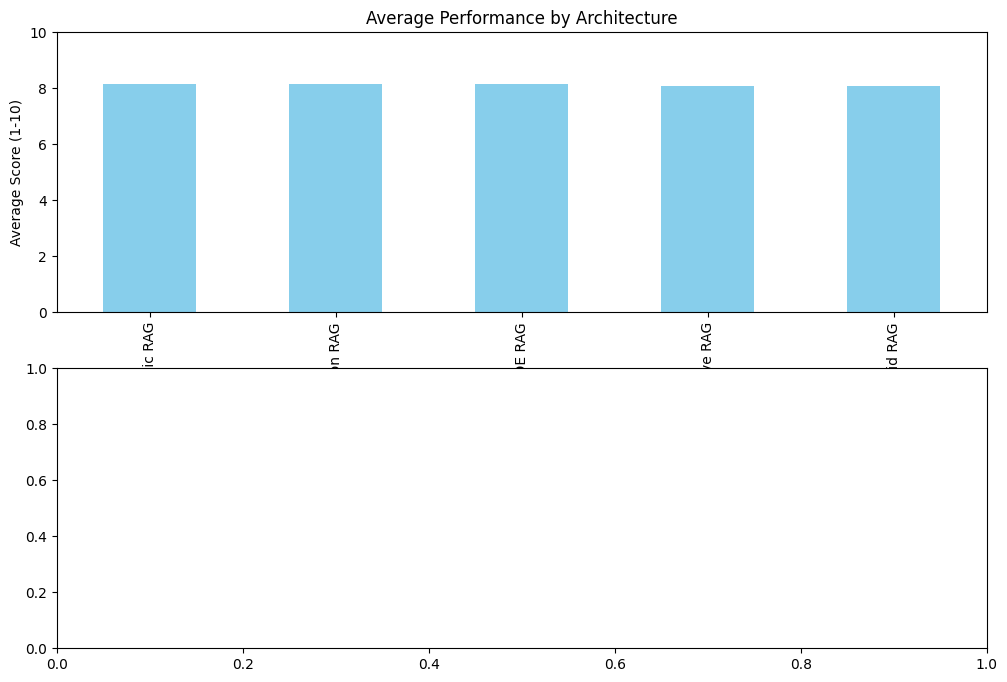

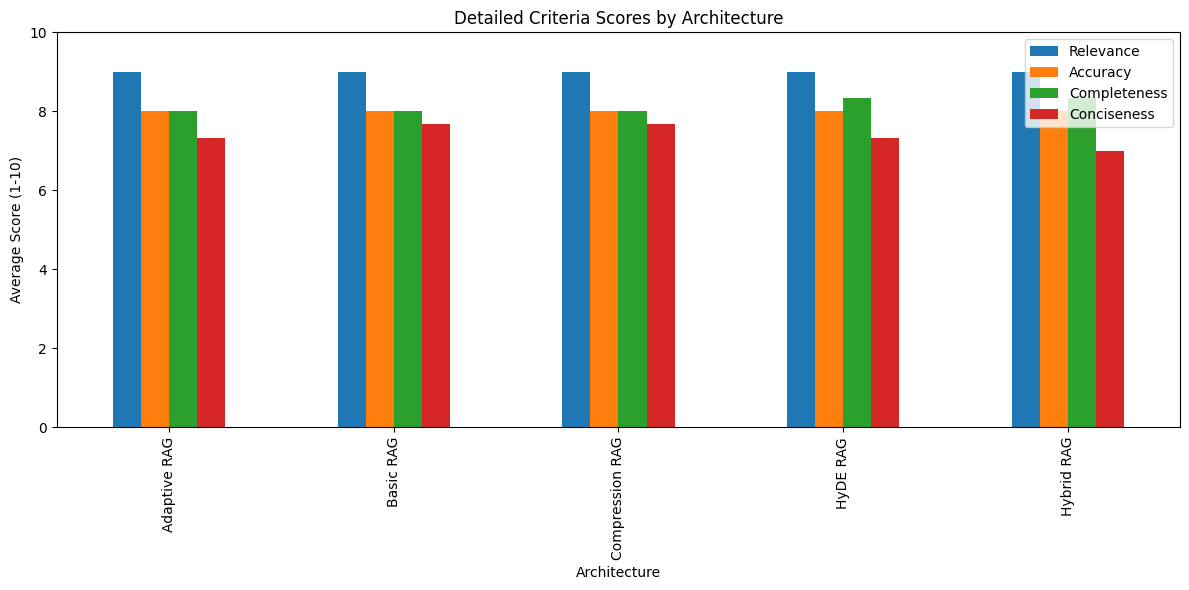

Performance visualization saved as 'rag_architecture_comparison.png'


In [ ]:
def visualize_rag_performance(comparison_results):
    """
    Create visualizations to compare RAG architectures
    """
    try:
        import matplotlib.pyplot as plt
        import pandas as pd
        
        # Extract scores from evaluations
        architectures = list(comparison_results["individual_results"].keys())
        queries = [result["query"] for result in comparison_results["individual_results"][architectures[0]]]
        
        # Create a dataframe for scores
        # Note: This requires parsing the evaluation text to extract scores, which is implementation-specific
        # Here's a simple example assuming scores are reported in a consistent format
        scores_data = []
        
        for arch_name, results in comparison_results["individual_results"].items():
            for result in results:
                # Extract scores from evaluation text (implementation may vary)
                eval_text = result["evaluation"]
                
                # Simple parser - finds numbers after criteria names
                relevance = extract_score(eval_text, "Relevance")
                accuracy = extract_score(eval_text, "Accuracy")
                completeness = extract_score(eval_text, "Completeness")
                conciseness = extract_score(eval_text, "Conciseness")
                
                scores_data.append({
                    "Architecture": arch_name,
                    "Query": result["query"],
                    "Relevance": relevance,
                    "Accuracy": accuracy,
                    "Completeness": completeness,
                    "Conciseness": conciseness,
                    "Average": (relevance + accuracy + completeness + conciseness) / 4
                })
        
        scores_df = pd.DataFrame(scores_data)
        
        # Create visualizations
        plt.figure(figsize=(12, 8))
        
        # Plot average scores by architecture
        plt.subplot(2, 1, 1)
        avg_by_arch = scores_df.groupby("Architecture")["Average"].mean().sort_values(ascending=False)
        avg_by_arch.plot(kind="bar", color="skyblue")
        plt.title("Average Performance by Architecture")
        plt.ylabel("Average Score (1-10)")
        plt.ylim(0, 10)
        
        # Plot detailed criteria scores by architecture
        plt.subplot(2, 1, 2)
        criteria = ["Relevance", "Accuracy", "Completeness", "Conciseness"]
        detailed_avg = scores_df.groupby("Architecture")[criteria].mean()
        detailed_avg.plot(kind="bar", figsize=(12, 6))
        plt.title("Detailed Criteria Scores by Architecture")
        plt.ylabel("Average Score (1-10)")
        plt.ylim(0, 10)
        
        plt.show()
        
        return scores_df
    
    except ImportError:
        print("Visualization requires matplotlib and pandas. Install with: pip install matplotlib pandas")
        return None

def extract_score(text, criterion):
    """Extract numerical score for a criterion from evaluation text"""
    import re
    
    # Look for patterns like "Relevance: 8/10" or "Relevance: 8"
    pattern = f"{criterion}:\\s*(\\d+)(?:/10)?"
    match = re.search(pattern, text)
    
    return int(match.group(1))

# Try to visualize results
try:
    performance_data = visualize_rag_performance(comparison_results)
except Exception as e:
    print(f"Visualization failed: {e}")

# LLM and RAGs evaluations

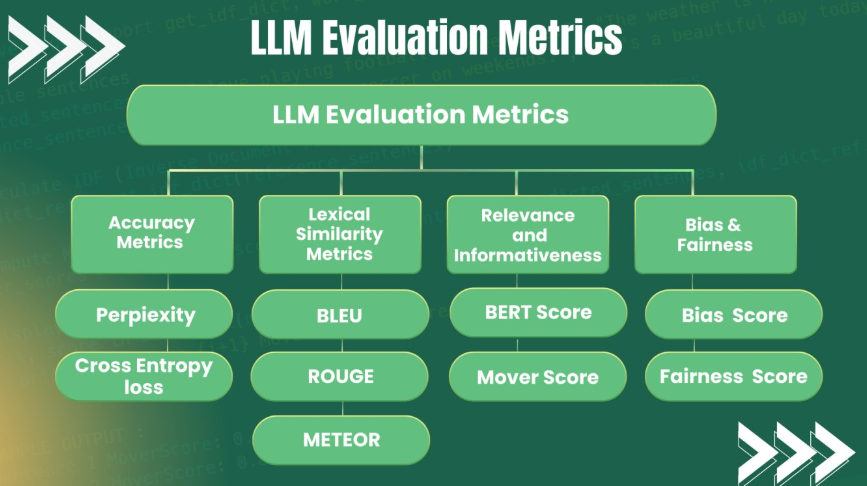

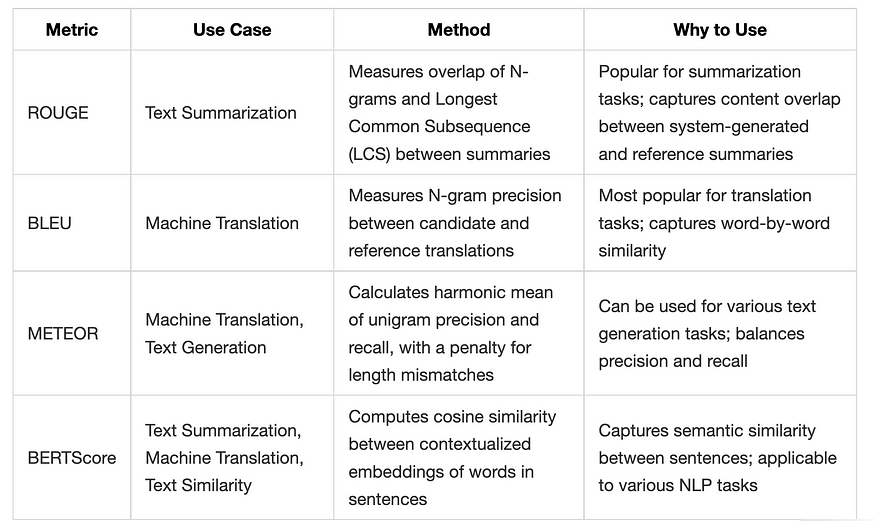

In [ ]:
import json

# Import evaluation libraries
from ragas.metrics import faithfulness, answer_relevancy, context_precision, answer_correctness
from ragas.llms import LangchainLLMWrapper
from ragas import evaluate
from datasets import Dataset

import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer

# Download NLTK resources
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Function to generate QA pairs from our corpus
def generate_qa_pairs(vectorstore, num_pairs=10):
    """
    Generate question-answer pairs from our vector store for evaluation
    """
    # Get documents from the vector store
    docs = vectorstore.similarity_search("", k=10)
    
    qa_generation_prompt = """
    Based on the following document, generate {num_pairs} diverse question-answer pairs.
    The questions should be answerable from the document and vary in complexity.
    
    Document:
    {document}
    
    Generate the QA pairs in the following JSON format:
    [
        {{"question": "question 1", "answer": "complete answer 1"}},
        {{"question": "question 2", "answer": "complete answer 2"}},
        ...
    ]
    
    Provide only the JSON array with no additional text.
    """
    
    # Combine some docs to create a representative sample
    combined_docs = []
    total_tokens = 0
    
    for doc in docs:
        # Roughly estimate tokens (4 chars ~= 1 token)
        doc_tokens = len(doc.page_content) // 4
        
        if total_tokens + doc_tokens > 4000:  # Keep within token limits
            break
            
        combined_docs.append(doc.page_content)
        total_tokens += doc_tokens
        
        if len(combined_docs) >= 5:  # Limit to max 5 docs
            break
    
    combined_text = "\n\n".join(combined_docs)
    
    # Generate QA pairs
    qa_pairs_raw = llm.invoke(
        qa_generation_prompt.format(
            num_pairs=num_pairs,
            document=combined_text
        )
    ).content
    
    # Extract JSON (handle case where model might add explanation)
    try:
        # First try to parse the entire response
        qa_pairs = json.loads(qa_pairs_raw)
    except json.JSONDecodeError:
        # If that fails, try to extract JSON array using regex
        import re
        json_match = re.search(r'\[.*\]', qa_pairs_raw, re.DOTALL)
        if json_match:
            try:
                qa_pairs = json.loads(json_match.group(0))
            except:
                # Fallback: manual extraction
                qa_pairs = []
                lines = qa_pairs_raw.strip().split('\n')
                current_question = None
                current_answer = None
                
                for line in lines:
                    if line.startswith('"question"'):
                        if current_question and current_answer:
                            qa_pairs.append({"question": current_question, "answer": current_answer})
                        current_question = line.split('"question": "')[1].split('"')[0]
                    elif line.startswith('"answer"'):
                        current_answer = line.split('"answer": "')[1].split('"')[0]
                
                if current_question and current_answer:
                    qa_pairs.append({"question": current_question, "answer": current_answer})
        else:
            # Last resort: ask the model to fix the JSON
            fix_prompt = f"The following text should be a JSON array of question-answer pairs but has formatting issues. Fix it and return only valid JSON:\n\n{qa_pairs_raw}"
            fixed_json = llm.invoke(fix_prompt).content
            try:
                qa_pairs = json.loads(fixed_json)
            except:
                # If all else fails, create a minimal set
                qa_pairs = [
                    {"question": "What is this document about?", "answer": "This document discusses transformers."}
                ]
    
    return qa_pairs

# Function to run RAG on a set of questions
def run_rag_evaluations(rag_architectures, qa_pairs):
    """
    Run all RAG architectures on the QA pairs and collect results
    """
    results = {}
    
    for name, rag_func in rag_architectures.items():
        print(f"Running {name} on evaluation set...")
        architecture_results = []
        
        for qa_pair in qa_pairs:
            question = qa_pair["question"]
            reference_answer = qa_pair["answer"]
            
            # Run the RAG architecture
            result = rag_func(question)
            
            # Store the results
            architecture_results.append({
                "question": question,
                "reference_answer": reference_answer,
                "generated_answer": result["answer"],
                "contexts": [doc.page_content for doc in result.get("source_documents", [])]
            })
        
        results[name] = architecture_results
    
    return results

# Configure RAG architectures for evaluation
rag_architectures = {
    "Basic RAG": basic_rag,
    "Compression RAG": compression_rag,
    "Hybrid RAG": hybrid_rag,
    "Adaptive RAG": adaptive_rag,
    "HyDE RAG": hyde_rag
}

d:\IT\Git-Projects\pjatk-teg\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Filip\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Filip\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Filip\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### Traditional NLP Evaluation Metrics


In [73]:
def calculate_nlp_metrics(generated_answers, reference_answers):
    """
    Calculate traditional NLP evaluation metrics (BLEU, METEOR, ROUGE)
    """
    metrics = {}
    
    # Initialize ROUGE scorer
    rouge = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    # Initialize BLEU smoothing
    smoothie = SmoothingFunction().method1
    
    # Calculate metrics
    bleu_scores = []
    meteor_scores = []
    rouge1_scores = []
    rouge2_scores = []
    rougeL_scores = []
    
    for gen, ref in zip(generated_answers, reference_answers):
        # Tokenize
        gen_tokens = nltk.word_tokenize(gen.lower())
        ref_tokens = nltk.word_tokenize(ref.lower())
        
        # BLEU
        bleu = sentence_bleu([ref_tokens], gen_tokens, smoothing_function=smoothie)
        bleu_scores.append(bleu)
        
        # METEOR
        meteor = meteor_score([ref_tokens], gen_tokens)
        meteor_scores.append(meteor)
        
        # ROUGE
        rouge_scores = rouge.score(ref, gen)
        rouge1_scores.append(rouge_scores['rouge1'].fmeasure)
        rouge2_scores.append(rouge_scores['rouge2'].fmeasure)
        rougeL_scores.append(rouge_scores['rougeL'].fmeasure)
    
    # Calculate averages
    metrics['bleu'] = sum(bleu_scores) / len(bleu_scores) if bleu_scores else 0
    metrics['meteor'] = sum(meteor_scores) / len(meteor_scores) if meteor_scores else 0
    metrics['rouge1'] = sum(rouge1_scores) / len(rouge1_scores) if rouge1_scores else 0
    metrics['rouge2'] = sum(rouge2_scores) / len(rouge2_scores) if rouge2_scores else 0
    metrics['rougeL'] = sum(rougeL_scores) / len(rougeL_scores) if rougeL_scores else 0
    
    return metrics

### RAGAS Evaluation


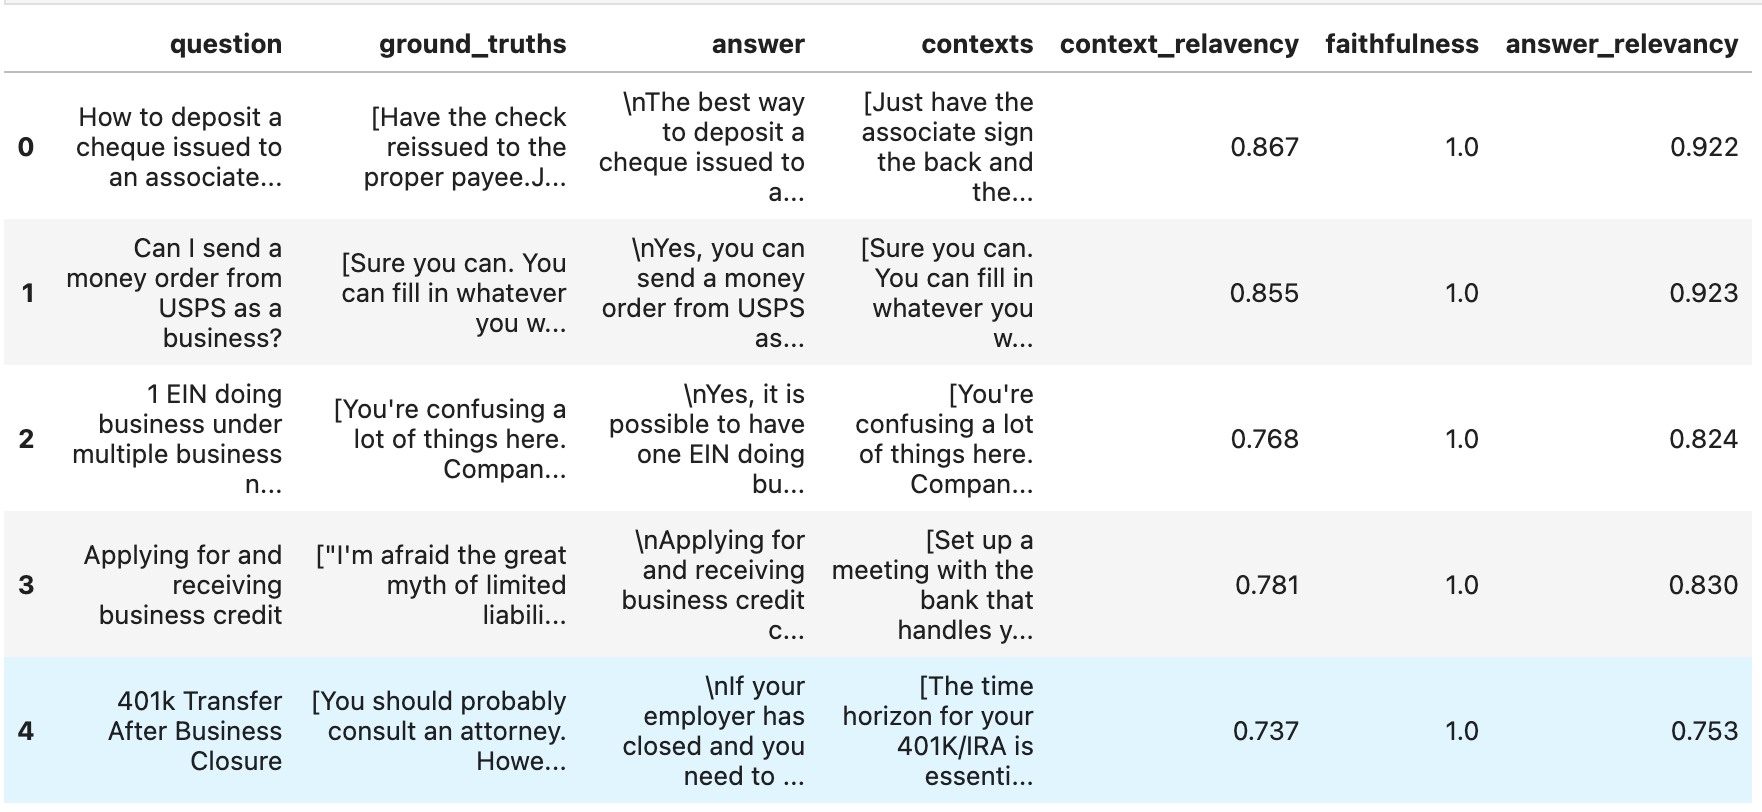

In [80]:
def evaluate_with_ragas(evaluation_results):
    """
    Evaluate RAG architectures using RAGAS metrics
    """
    ragas_results = {}
    
    # Initialize Ragas with our LLM
    evaluator_llm = ChatOpenAI(api_key=openai_api_key, model="gpt-4o", temperature=0)
    ragas_llm = LangchainLLMWrapper(evaluator_llm)
    
    for arch_name, results in evaluation_results.items():
        print(f"Evaluating {arch_name} with RAGAS...")
        
        # Prepare data for RAGAS
        questions = [r["question"] for r in results]
        contexts = [r["contexts"] for r in results]
        generated_answers = [r["generated_answer"] for r in results]
        reference_answers = [r["reference_answer"] for r in results]
        
        # Create dataset
        dataset_dict = {
            "question": questions,
            "contexts": contexts,
            "answer": generated_answers,
            "ground_truth": reference_answers
        }
        
        dataset = Dataset.from_dict(dataset_dict)
        
        # Define RAGAS metrics
        metrics = [
            answer_relevancy,
            faithfulness,
            context_precision,
            answer_correctness
        ]
        
        # Run evaluation
        try:
            eval_results = evaluate(
                dataset=dataset,
                metrics=metrics,
                llm=ragas_llm
            )
            
            # Convert to simple dict for easier handling
            ragas_results[arch_name] = {
                metric: float(eval_results[metric]) for metric in eval_results
            }
            
        except Exception as e:
            print(f"RAGAS evaluation failed for {arch_name}: {e}")
            ragas_results[arch_name] = {
                "error": str(e)
            }
        
        # Add traditional NLP metrics
        traditional_metrics = calculate_nlp_metrics(generated_answers, reference_answers)
        ragas_results[arch_name].update(traditional_metrics)
    
    return ragas_results

### Visualize evaluation results


In [78]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

def visualize_evaluation_results(ragas_results):
    """
    Create visualizations of evaluation results
    """
    try:
        
        # Convert results to DataFrame
        data = []
        for arch_name, metrics in ragas_results.items():
            row = {"Architecture": arch_name}
            row.update(metrics)
            data.append(row)
        
        df = pd.DataFrame(data)
        
        # Filter out any non-numeric columns except 'Architecture'
        numeric_cols = ['Architecture'] + [col for col in df.columns if col != 'Architecture' and pd.api.types.is_numeric_dtype(df[col])]
        df = df[numeric_cols]
        
        # Create heatmap
        plt.figure(figsize=(12, 8))
        
        # Reformat data for heatmap
        heatmap_data = df.set_index('Architecture')
        
        # Plot heatmap
        sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', linewidths=0.5, fmt=".3f")
        plt.title('RAG Architecture Evaluation Results')
        plt.tight_layout()
        plt.savefig('rag_evaluation_heatmap.png')
        
        # Create bar charts for key metrics
        metric_groups = {
            'RAGAS Metrics': ['answer_relevancy', 'faithfulness', 'context_relevancy', 'context_precision'],
            'Traditional Metrics': ['bleu', 'meteor', 'rouge1', 'rouge2', 'rougeL']
        }
        
        for group_name, metrics in metric_groups.items():
            # Filter to only metrics that exist in our data
            available_metrics = [m for m in metrics if m in df.columns]
            if not available_metrics:
                continue
                
            plt.figure(figsize=(14, 6))
            
            # Create bar chart for each metric
            df_subset = df[['Architecture'] + available_metrics].melt(
                id_vars=['Architecture'],
                var_name='Metric',
                value_name='Score'
            )
            
            sns.barplot(x='Architecture', y='Score', hue='Metric', data=df_subset)
            plt.title(f'{group_name} by Architecture')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.savefig(f'rag_evaluation_{group_name.lower().replace(" ", "_")}.png')
        
        plt.close('all')
        print("Visualizations saved as PNG files")
        
    except ImportError:
        print("Visualization requires matplotlib, pandas, and seaborn. Install with: pip install matplotlib pandas seaborn")



### Evaluate system

In [ ]:
def main_evaluation():
    # Step 1: Generate QA pairs for evaluation
    print("Generating evaluation question-answer pairs...")
    qa_pairs = generate_qa_pairs(vectorstore, num_pairs=5)  # Start with 5 for faster testing
    
    # Step 2: Run all RAG architectures on the evaluation set
    print("\nRunning RAG architectures on evaluation set...")
    evaluation_results = run_rag_evaluations(rag_architectures, qa_pairs)
    
    # Step 3: Evaluate using RAGAS and traditional metrics
    print("\nEvaluating results with RAGAS and NLP metrics...")
    ragas_results = evaluate_with_ragas(evaluation_results)
    
    # Step 4: Visualize the results
    print("\nVisualizing evaluation results...")
    visualize_evaluation_results(ragas_results)
    
    # Step 5: Generate summary analysis
    print("\nGenerating analysis of evaluation results...")
    analysis_prompt = """
    Based on the following evaluation results for different RAG architectures:
    
    {results}
    
    Provide a detailed analysis covering:
    1. Which architecture performed best overall?
    2. Which architecture performed best for each specific metric?
    3. What do these results tell us about the strengths and weaknesses of each approach?
    4. What recommendations would you make for different use cases?
    
    Focus on both RAGAS metrics (answer_relevancy, faithfulness, context_relevancy, etc.) 
    and traditional NLP metrics (BLEU, METEOR, ROUGE).
    """
    
    # Format results for the prompt
    results_text = "\n".join([
        f"{arch_name}:\n" + "\n".join([f"- {metric}: {value}" for metric, value in metrics.items() if not metric == 'error'])
        for arch_name, metrics in ragas_results.items()
    ])
    
    analysis = llm.invoke(analysis_prompt.format(results=results_text)).content
    print("\nEvaluation Analysis:\n")
    print(analysis)
    
    return {
        "qa_pairs": qa_pairs,
        "evaluation_results": evaluation_results,
        "ragas_results": ragas_results,
        "analysis": analysis
    }

main_evaluation()

Generating evaluation question-answer pairs...

Running RAG architectures on evaluation set...
Running Basic RAG on evaluation set...
Running Compression RAG on evaluation set...
